# Imports

In [1]:
import os
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'

# Load one sample

In [ ]:
%run ../common/__init__.py

In [ ]:
DATASET_DIR = os.environ.get('DATASET_DIR_CHEXPERT')
image_fpath = os.path.join(DATASET_DIR, 'train/patient00001/study1/view1_frontal.jpg')

In [ ]:
image = Image.open(image_fpath).convert('RGB')
image.size

In [ ]:
image = np.array(image)
image.shape

In [ ]:
plt.imshow(image)

# Calculate mean and std

In [ ]:
%run ../../utils/images.py

In [ ]:
fpath = os.path.join(DATASET_DIR, 'train.csv')
d = pd.read_csv(fpath)
d.replace(r'CheXpert-v1.0-small/', '', regex=True, inplace=True)
d.head()

In [ ]:
train_images_all = list(d['Path'])
len(train_images_all)

In [ ]:
train_images_frontal = list(d[d['Frontal/Lateral'] == 'Frontal']['Path'])
len(train_images_frontal)

In [ ]:
mean, std = compute_mean_std(ImageFolderIterator(DATASET_DIR, train_images_all), show=True)
mean, std

In [ ]:
stats_frontal = compute_mean_std(ImageFolderIterator(DATASET_DIR, train_images_frontal),
                                 show=True)
stats_frontal

# Load `ChexpertDataset` class

In [3]:
%run ../chexpert.py
%run ../../utils/common.py

In [15]:
dataset = ChexpertDataset(dataset_type='train', frontal_only=True)
len(dataset)

191027

In [18]:
item = dataset[5]
item.image.size(), item.image.min(), item.image.max()

(torch.Size([3, 512, 512]), tensor(-1.7496), tensor(1.7047))

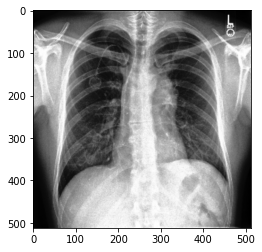

In [19]:
plt.imshow(tensor_to_range01(item.image).permute(1, 2, 0))

# Exploratory analysis

In [ ]:
%run ../chexpert.py

In [ ]:
train_dataset = ChexpertDataset(dataset_type='train', frontal_only=False)
val_dataset = ChexpertDataset(dataset_type='val', frontal_only=False)
len(train_dataset), len(val_dataset)

## Frontal vs lateral

Amount of images

In [ ]:
def print_frontal_vs_lateral(dataset):
    counter = Counter(dataset.label_index['Frontal/Lateral'])
    print(dataset.dataset_type)
    for key in counter.keys():
        amount = counter[key]
        perc = amount / len(dataset) * 100
        print(f'\t{key}: {amount:,} ({perc:.1f}%)')

In [ ]:
print_frontal_vs_lateral(train_dataset)
print_frontal_vs_lateral(val_dataset)

## Diseases distribution

In [ ]:
def amounts_by_disease(dataset):
    amounts = dataset.label_index[CHEXPERT_DISEASES].sum(axis=0).sort_values()

    print(dataset.dataset_type)
    for disease in amounts.keys():
        amount = int(amounts[disease])
        perc = amount / len(dataset) * 100
        print(f'\t{disease:<28}: {amount:<7,} ({perc:.1f}%)')

In [ ]:
amounts_by_disease(train_dataset)
amounts_by_disease(val_dataset)

In [ ]:
def plot_amounts_by_disease(dataset):
    amounts = dataset.label_index[CHEXPERT_DISEASES].sum(axis=0).sort_values()
    
    plt.title(dataset.dataset_type)
    plt.bar(amounts.keys(), amounts)
    plt.xticks(rotation=90)
    plt.ylabel('Amount')

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plot_amounts_by_disease(train_dataset)

plt.subplot(1, 2, 2)
plot_amounts_by_disease(val_dataset)